# ATP Tennis Data - Other Classifiers

In our previous [notebook](https://github.com/sv650s/sb-capstone2/blob/master/notebooks/4-atp_logistic_regression.ipynb), we used logistic regression to see how accurately we can predict winners and losers of a tennis match. In this notebook, we will use a number of different classifiers to see how they perform.


Summary of findings from previous notebook:

* diffing player stats was a better way of engineering our features
* loading more data (older that 1998, didn't help with our prediction)

Results from logistic regression:
```
              precision    recall  f1-score   support

        Loss       0.69      0.66      0.67     12468
         Win       0.68      0.71      0.69     12521

    accuracy                           0.68     24989
   macro avg       0.68      0.68      0.68     24989
weighted avg       0.68      0.68      0.68     24989
```


Again, our null hypothesis is that we can predict purely based on the player ranking - so our baseline is ~65% accruracy if we use match data from 1998 to present.

We will use the following classifiers - all using default settings
* KNN
* Random Forest
* SVC


In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc
from sklearn.decomposition import PCA
from datetime import datetime
import pickle
import json

%matplotlib inline
sns.set()


# date
DATE_FORMAT = '%Y-%m-%d'
DATE = datetime.now().strftime(DATE_FORMAT)

# files
DATASET_DIR = '../datasets'
FEATURE_FILE_DIFF = f'{DATASET_DIR}/atp_matches_1998-2019_features-diff.csv'
MODEL_DIR = '../models'
MODEL_FILE = f'{MODEL_DIR}/{DATE}-knn-diff.csv'

REPORT_DIR = '../reports'
REFPORT_FILE = f'{REPORT_DIR}/report.csv'

LABEL_COL = 'p1_winner'

# random seed
RSTATE = 1
N_JOBS = 4
MAX_ITER = 100



In [21]:
def analyze_predictions(y_test, y_predict, y_predict_proba):
    if y_predict_proba:
        print(roc_auc_score(y_test, y_predict_proba))
    
    print(classification_report(y_test, y_predict, target_names=['Loss', 'Win']))
    cm = pd.DataFrame(confusion_matrix(y_test, y_predict), index=['Loss', 'Win'], 
                  columns = ['Loss', 'Win'])
    print(cm)
    sns.heatmap(cm, annot=True)

In [48]:
from sklearn.preprocessing import MinMaxScaler



def plot_2d(X_test, y_predict):
    
    # normalize our data first before using PCA so weights are the same for all variables
    mms = MinMaxScaler()
    normalized_df = X_test.copy()
    for col in normalized_df.columns:
        normalized_col = mms.fit_transform(normalized_df[col].values)
        normalized_df[col] = normalized_col
    

    # reduce X to 2D
    X_test_2d = pd.DataFrame(PCA(n_components=2).fit_transform(X_test))
#     print(X_test_2d.head())

    # let's figure out which ones of these are predicted Wins
    wins = X_test_2d[y_predict == 1]

    # entries that are predicted losses
    losses = X_test_2d[y_predict == 0]

    f, a = plt.subplots(1, 1, figsize=(20,10))
    p = sns.scatterplot(x=0, y=1, data=losses, ax=a, color='r', alpha=0.5)
    p = sns.scatterplot(x=0, y=1, data=wins, ax=a, color='b', alpha=0.5)


# Use KNN classifier with default setting

In [4]:
# extract features and labels
features = pd.read_csv(f'{FEATURE_FILE_DIFF}')
labels = features[LABEL_COL].copy()
features = features.drop([LABEL_COL], axis=1)

# train our model
X_train, X_test, y_train, y_test = \
        train_test_split(features, labels, random_state=RSTATE)
knn = KNeighborsClassifier(n_jobs = N_JOBS).fit(X_train, y_train)
y_predict = knn.predict(X_test)


In [7]:
knn.score(X_test, y_test)

0.6091795119928112

In [5]:
print(classification_report(y_test, y_predict, target_names=['Loss', 'Win']))

              precision    recall  f1-score   support

        Loss       0.60      0.62      0.61      7115
         Win       0.62      0.60      0.61      7352

    accuracy                           0.61     14467
   macro avg       0.61      0.61      0.61     14467
weighted avg       0.61      0.61      0.61     14467



      Loss   Win
Loss  4437  2678
Win   2976  4376


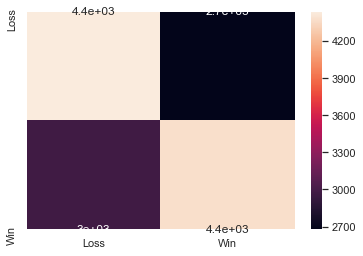

In [6]:
cm = pd.DataFrame(confusion_matrix(y_test, y_predict), index=['Loss', 'Win'], 
                  columns = ['Loss', 'Win'])
print(cm)
sns.heatmap(cm, annot=True)

# Random Forest Classifier

In [9]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier().fit(X_train, y_train)
y_predict = rf.predict(X_test)
rf.score(X_test, y_test)

/anaconda3/envs/capstone2/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.8563627566185111

In [10]:
print(classification_report(y_test, y_predict, target_names=['Loss', 'Win']))

              precision    recall  f1-score   support

        Loss       0.82      0.90      0.86      7115
         Win       0.90      0.81      0.85      7352

    accuracy                           0.86     14467
   macro avg       0.86      0.86      0.86     14467
weighted avg       0.86      0.86      0.86     14467



      Loss   Win
Loss  6416   699
Win   1379  5973


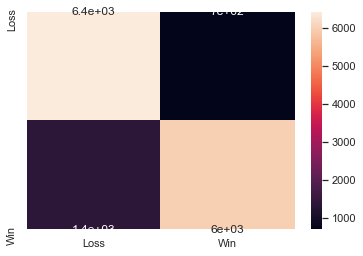

In [11]:
cm = pd.DataFrame(confusion_matrix(y_test, y_predict), index=['Loss', 'Win'], 
                  columns = ['Loss', 'Win'])
print(cm)
sns.heatmap(cm, annot=True)

# Let's try SVC

In [13]:
from sklearn.svm import SVC

svc = SVC().fit(X_train, y_train)
y_predict_svc = svc.predict(X_test)
svc.score(X_test, y_test)

/anaconda3/envs/capstone2/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


0.4968549111771618

              precision    recall  f1-score   support

        Loss       0.49      1.00      0.66      7115
         Win       0.92      0.01      0.02      7352

    accuracy                           0.50     14467
   macro avg       0.71      0.50      0.34     14467
weighted avg       0.71      0.50      0.34     14467

      Loss  Win
Loss  7108    7
Win   7272   80


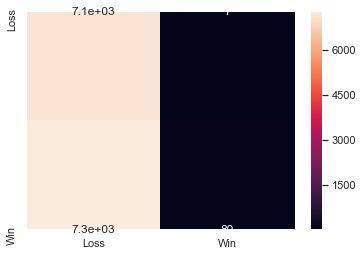

In [15]:
analyze_predictions(y_test, y_predict_svc)

Wow.. SVC is pretty much prediction all matches at a lost which would make sense that our precision is around 50% as our data is balanced, but you can see that recall is at 1% meaning it's only 1% effective at actually identifying wins

### Let's visualize our classification

We will use PCA to reduce the dimensions to 2D then graph our data

In [49]:
plot_2d(X_test, y_predict_svc)

ValueError: Expected 2D array, got 1D array instead:
array=[-4.62  0.86 -2.34 ... -0.16 -0.83  2.65].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.